## Feature Selection & Dimensionality reduction



In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
import getpass
from modshogun import *

# below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

%matplotlib inline
plt.style.use('ggplot')

In [2]:
query_output = pd.read_csv('./full-features-materialized.csv') #.dropna().reset_index(drop=True)

query_output.first_careunit = pd.Categorical(query_output.first_careunit)
query_output.gender = pd.Categorical(query_output.gender)
query_output.admission_type = pd.Categorical(query_output.admission_type)

query_output['gender'] = query_output.gender.cat.codes
query_output['first_careunit'] = query_output.first_careunit.cat.codes
query_output['admission_type'] = query_output.admission_type.cat.codes

query_output = query_output[(query_output.exclusion_los == 0) & (query_output.exclusion_age == 0) 
                            & (query_output.exclusion_first_stay == 0) ]#& (query_output.age_icu_in < 250)]

# Median age of patients > 89 is 91.6
query_output.loc[query_output.age_icu_in > 89, 'age_icu_in'] = 91.6

mortality_names = ['hospital_expire_flag', 'icu_expire_flag', 
                   'hospital1year_expire_flag', 'hospital30day_expire_flag']

los_names = ['hosp_los', 'icu_los']

feature_names = [
            # Demographic information
            'age_icu_in', 'gender', 'first_careunit',
            'admission_type',
    
            # Vital signs
            'heartrate_min', 'heartrate_max', 
            'meanbp_min', 'meanbp_max', 
            'diasbp_min', 'diasbp_max',
            'sysbp_min', 'sysbp_max',
            'resprate_min', 'resprate_max',
            'mingcs', 'gcsmotor',
            'gcsverbal', 'gcseyes',             
            'tempc_min', 'tempc_max',
            'spo2_min', 'spo2_max',
                 
            # Laboratory measurements
            
            'aniongap_min', 'aniongap_max',
            #'albumin_min', 'albumin_max',
            #'bands_min', 'bands_max',
            'bicarbonate_min', 'bicarbonate_max',
            #'bilirubin_min', 'bilirubin_max',
            'creatinine_min', 'creatinine_max',
            'chloride_min', 'chloride_max',
            'glucose_min', 'glucose_max',
            'hematocrit_min', 'hematocrit_max',
            'hemoglobin_min', 'hemoglobin_max',
            #'lactate_min', 'lactate_max',
            'platelet_min', 'platelet_max',
            'potassium_min', 'potassium_max',
            #'ptt_min', 'ptt_max',
            #'inr_min', 'inr_max',
            #'pt_min', 'pt_max',
            'sodium_min', 'sodium_max',
            'bun_min', 'bun_max',
            'wbc_min', 'wbc_max',                 
            
            # Other
            'vent', 
            'urineoutput'
            ]

query_output = query_output.loc[:, mortality_names + feature_names]
query_output = query_output.fillna(query_output.mean()).reset_index(drop=True)

# query_output = query_output.loc[:, mortality_names + feature_names].dropna().reset_index(drop=True)

outcomes = query_output.loc[:, mortality_names]
features = query_output.loc[:, query_output.columns.difference(mortality_names + los_names)]

X = features
y = outcomes['hospital_expire_flag'].replace(0, -1)

print(len(query_output))
query_output.tail()

32290


,hospital_expire_flag,icu_expire_flag,hospital1year_expire_flag,hospital30day_expire_flag,age_icu_in,gender,first_careunit,admission_type,heartrate_min,heartrate_max,...,potassium_min,potassium_max,sodium_min,sodium_max,bun_min,bun_max,wbc_min,wbc_max,vent,urineoutput
32285,0,0,0,0,70.826046,0,5,0,62.0,119.0,...,3.1,3.9,135.0,144.0,7.0,7.0,3.3,4.5,1,1995.0
32286,0,0,0,0,63.893494,0,2,1,60.0,95.0,...,3.5,3.9,139.0,143.0,16.0,31.0,5.3,8.6,0,1400.0
32287,0,0,0,0,43.594414,0,0,1,58.0,80.0,...,3.8,4.1,139.0,140.0,12.0,13.0,11.7,11.8,0,1250.0
32288,1,1,1,1,86.957864,1,2,1,52.0,68.0,...,5.0,5.7,123.0,128.0,41.0,42.0,11.4,13.3,1,730.0
32289,0,0,0,0,77.488270,1,0,1,28.0,74.0,...,4.4,4.9,135.0,138.0,21.0,22.0,10.8,11.0,0,1800.0


## Principal Component Analysis

In [3]:
split = int(len(X) * 0.7)

X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

print("Number of training samples:", y_train.get_num_labels())
print("Number of testing samples:", y_test.get_num_labels())

('Number of training samples:', 22603)
('Number of testing samples:', 9687)


In [4]:
preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

True

In [5]:
preprocessor = PCA(AUTO)

preprocessor.set_target_dim(48)

preprocessor.init(X_train)

E = preprocessor.get_transformation_matrix()
mean = preprocessor.get_mean()

#Get all the eigenvalues returned by PCA.
eig_value = preprocessor.get_eigenvalues()

print(eig_value)

X_transformed = preprocessor.apply_to_feature_matrix(X_train).T

print(X_transformed[:, 0])

[ 0.01518624  0.02105273  0.04639135  0.05442586  0.0594758   0.06029003
  0.09052768  0.12873543  0.13550631  0.21896065  0.22534858  0.22726647
  0.25028809  0.27740557  0.32681767  0.35340083  0.36384161  0.42265185
  0.4401412   0.44916387  0.47917281  0.51201246  0.57479038  0.63759838
  0.66896667  0.70007504  0.78275744  0.78933194  0.84620183  0.87661971
  0.90882884  0.95284362  0.99164835  1.01047059  1.18407776  1.26703612
  1.32142152  1.39900352  1.5517613   1.70586037  1.80320696  2.16376457
  2.41615497  2.60386819  2.71934855  3.6816201   4.34371495  4.94308891]
[ 0.01688562 -0.17268246  0.04270941 ...,  0.00933425  0.02306006
  0.0579221 ]


In [6]:
preprocessor = PCA(AUTO)

preprocessor.set_target_dim(2)

preprocessor.init(X_train)

E = preprocessor.get_transformation_matrix()
mean = preprocessor.get_mean()

#Get all the eigenvalues returned by PCA.
eig_value = preprocessor.get_eigenvalues()

print(eig_value)

#X_transformed = preprocessor.apply_to_feature_matrix(X_train).T

#print(X_transformed[0, :])

[ 0.01518624  0.02105273  0.04639135  0.05442586  0.0594758   0.06029003
  0.09052768  0.12873543  0.13550631  0.21896065  0.22534858  0.22726647
  0.25028809  0.27740557  0.32681767  0.35340083  0.36384161  0.42265185
  0.4401412   0.44916387  0.47917281  0.51201246  0.57479038  0.63759838
  0.66896667  0.70007504  0.78275744  0.78933194  0.84620183  0.87661971
  0.90882884  0.95284362  0.99164835  1.01047059  1.18407776  1.26703612
  1.32142152  1.39900352  1.5517613   1.70586037  1.80320696  2.16376457
  2.41615497  2.60386819  2.71934855  3.6816201   4.34371495  4.94308891]


## 2D representation using PCA

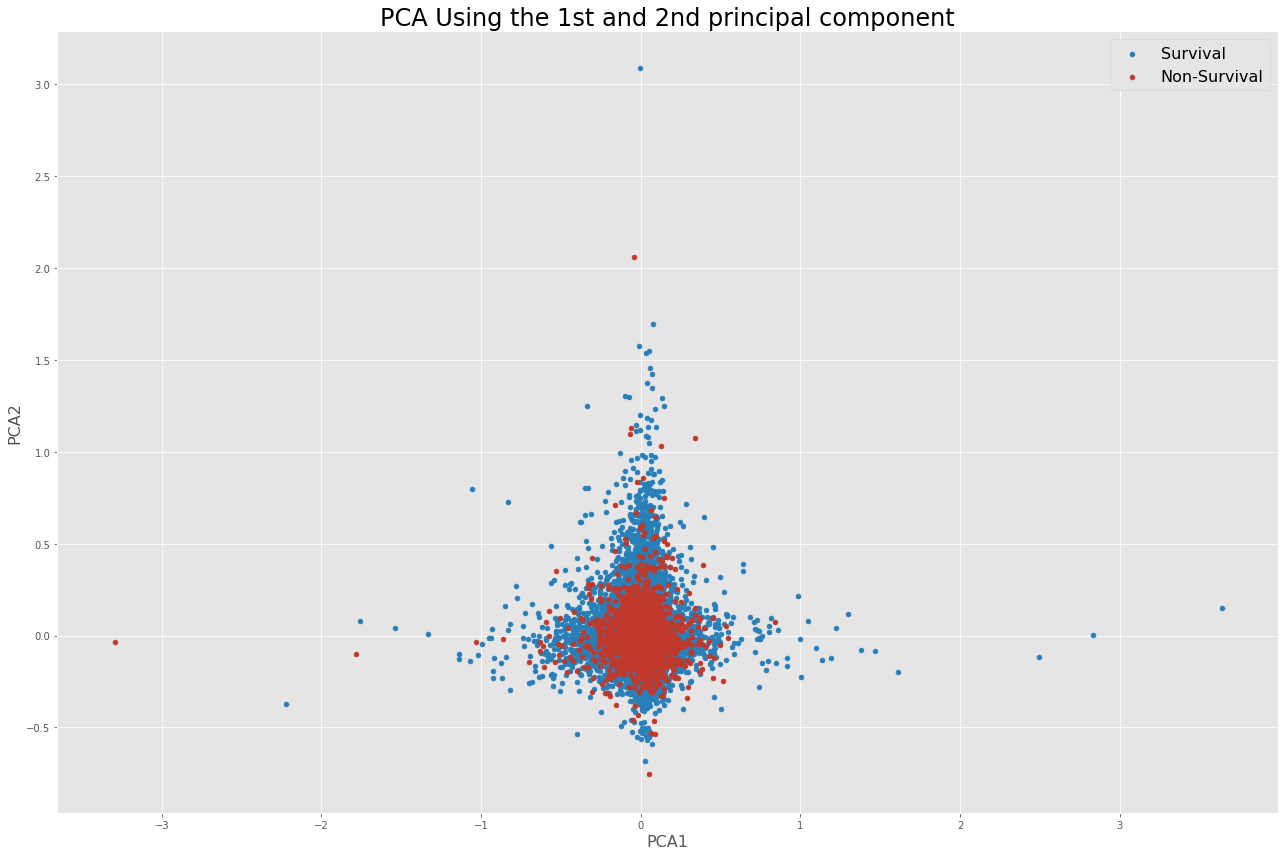

In [10]:
fig, plot = plt.subplots(figsize=(18, 12))
#fig.set_size_inches(25, 25)
plt.prism()

# X_transformed = preprocessor.apply_to_feature_matrix(X_train).T # this crashes when ran twice
colors = [
    ('#2980b9', 'o'), # blue
    ('#c0392b', 'o'), # red

]

labels = np.unique(y_train.get_labels())

for num in range(len(labels)):
    plt.scatter([X_transformed[:,0][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]],
    [X_transformed[:,1][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]], 25,
    label=['Survival', 'Non-Survival'][num], color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1, fontsize=16)
plt.title("PCA Using the 1st and 2nd principal component", fontsize=24)
#plot.set_xticks(())
#plot.set_yticks(())
plt.xlabel('PCA1', fontsize=16)
plt.ylabel('PCA2', fontsize=16)
plt.tight_layout()

## Retained variance vs performance

In [11]:
X_train = RealFeatures(np.array(X[:split].T))
X_test = RealFeatures(np.array(X[split:].T))

y_train = BinaryLabels(np.array(y[:split]))
y_test = BinaryLabels(np.array(y[split:]))

preprocessor = PruneVarSubMean(True)
preprocessor.init(X_train)
X_train.add_preprocessor(preprocessor)
X_train.apply_preprocessor(True)

preprocessor.init(X_test)
X_test.add_preprocessor(preprocessor)
X_test.apply_preprocessor(True)

preprocessor = PCA(AUTO)
preprocessor.set_target_dim(48)
preprocessor.init(X_train)
X_transformed = preprocessor.apply_to_feature_matrix(X_train)
X_test_transformed = preprocessor.apply_to_feature_matrix(X_test)

n_components = [2, 4, 8, 10, 16, 20, 24, 32, 40, 44, 48]
rm = []
aucs = []
eigen_sum = sum(eig_value)

# Parameters to svm
C = 0.1
epsilon = 0.001

for component in n_components:
    
    X_train = X_transformed[:component, :]
    X_test = X_test_transformed[:component, :]

    X_train = RealFeatures(X_train)
    X_test = RealFeatures(X_test)
    
    lr = LibLinear(C, X_train, y_train)
    lr.set_liblinear_solver_type(L2R_LR)
    lr.set_epsilon(epsilon)

    lr.train()

    y_pred = lr.apply(X_test)

    lr_roc = ROCEvaluation()
    lr_roc.evaluate(y_pred, y_test)

    auc = lr_roc.get_auROC()
    print("Area under ROC(%):", auc, "(%d components)" % component)    
        
    aucs.append(auc)
    
    retained_variance = sum(eig_value[:component]) / eigen_sum
    
    rm.append(retained_variance)

('Area under ROC(%):', 0.5126518085701792, '(2 components)')
('Area under ROC(%):', 0.539211559619722, '(4 components)')
('Area under ROC(%):', 0.5526297771195736, '(8 components)')
('Area under ROC(%):', 0.5486884058312623, '(10 components)')
('Area under ROC(%):', 0.5664400664400573, '(16 components)')
('Area under ROC(%):', 0.5698240290077, '(20 components)')
('Area under ROC(%):', 0.6002738553758937, '(24 components)')
('Area under ROC(%):', 0.6438200927996828, '(32 components)')
('Area under ROC(%):', 0.7111868540440038, '(40 components)')
('Area under ROC(%):', 0.764618172781434, '(44 components)')
('Area under ROC(%):', 0.8467379691869136, '(48 components)')


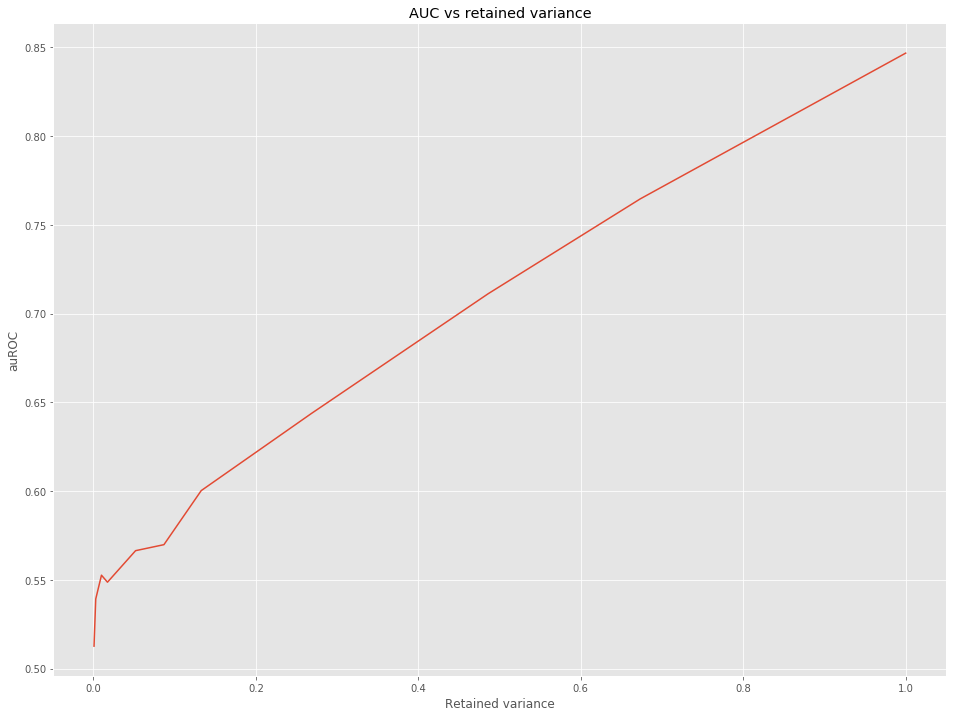

In [159]:
plt.figure(figsize=(16, 12))

plt.plot(rm, aucs)
plt.xlabel("Retained variance")
plt.ylabel("auROC")

plt.title("AUC vs retained variance")

## Isomap

In [87]:
%%time

# create instance of Isomap converter and configure it
isomap = Isomap()
isomap.set_target_dim(2)
# set the number of neighbours used in kNN search
isomap.set_k(20)

# embed data
embedded_data_isomap = isomap.embed(X_train).get_feature_matrix()


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: [WARN] In file /build/shogun-v9ad6W/shogun-6.0.0+1SNAPSHOT201704270057/src/shogun/lib/tapkee/tapkee_shogun.cpp line 35: The neighborhood graph is not connected.

  if __name__ == '__main__':


CPU times: user 31min 52s, sys: 11.9 s, total: 32min 4s
Wall time: 15min 6s


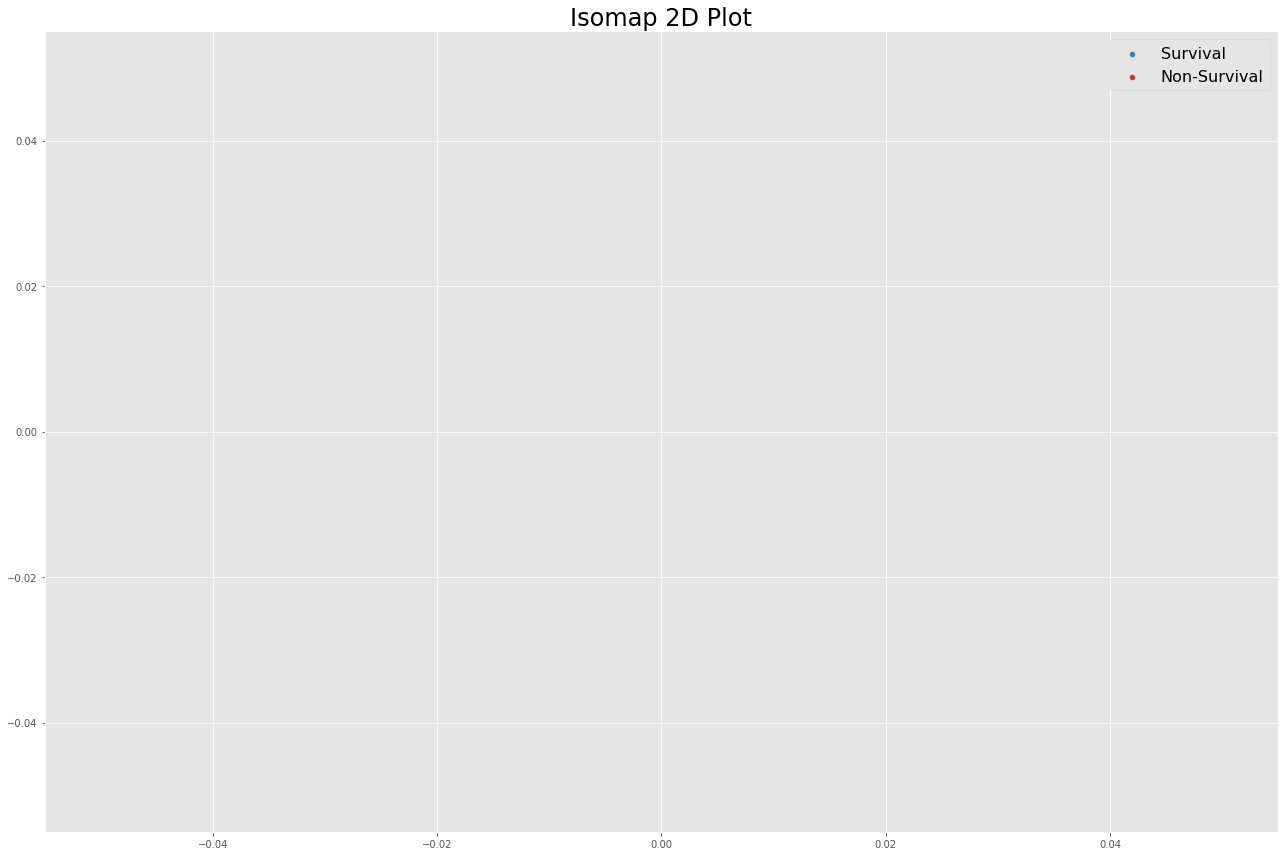

In [90]:
fig, plot = plt.subplots(figsize=(18, 12))
#fig.set_size_inches(25, 25)
plt.prism()

# X_transformed = preprocessor.apply_to_feature_matrix(X_train).T # this crashes when ran twice
colors = [
    ('#2980b9', 'o'), # blue
    ('#c0392b', 'o'), # red

]

labels = np.unique(y_train.get_labels())

for num in range(len(labels)):
    plt.scatter([embedded_data_isomap.T[:,0][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]],
    [embedded_data_isomap.T[:,1][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]], 25,
    label=['Survival', 'Non-Survival'][num], color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1, fontsize=16)
plt.title("Isomap 2D Plot", fontsize=24)
#plot.set_xticks(())
#plot.set_yticks(())
plt.tight_layout()

## t-SNE

In [11]:
tsne = TDistributedStochasticNeighborEmbedding()

tsne.set_target_dim(2)
tsne.set_perplexity(25)

embedded_data_tsne = tsne.embed(X_train).get_feature_matrix()

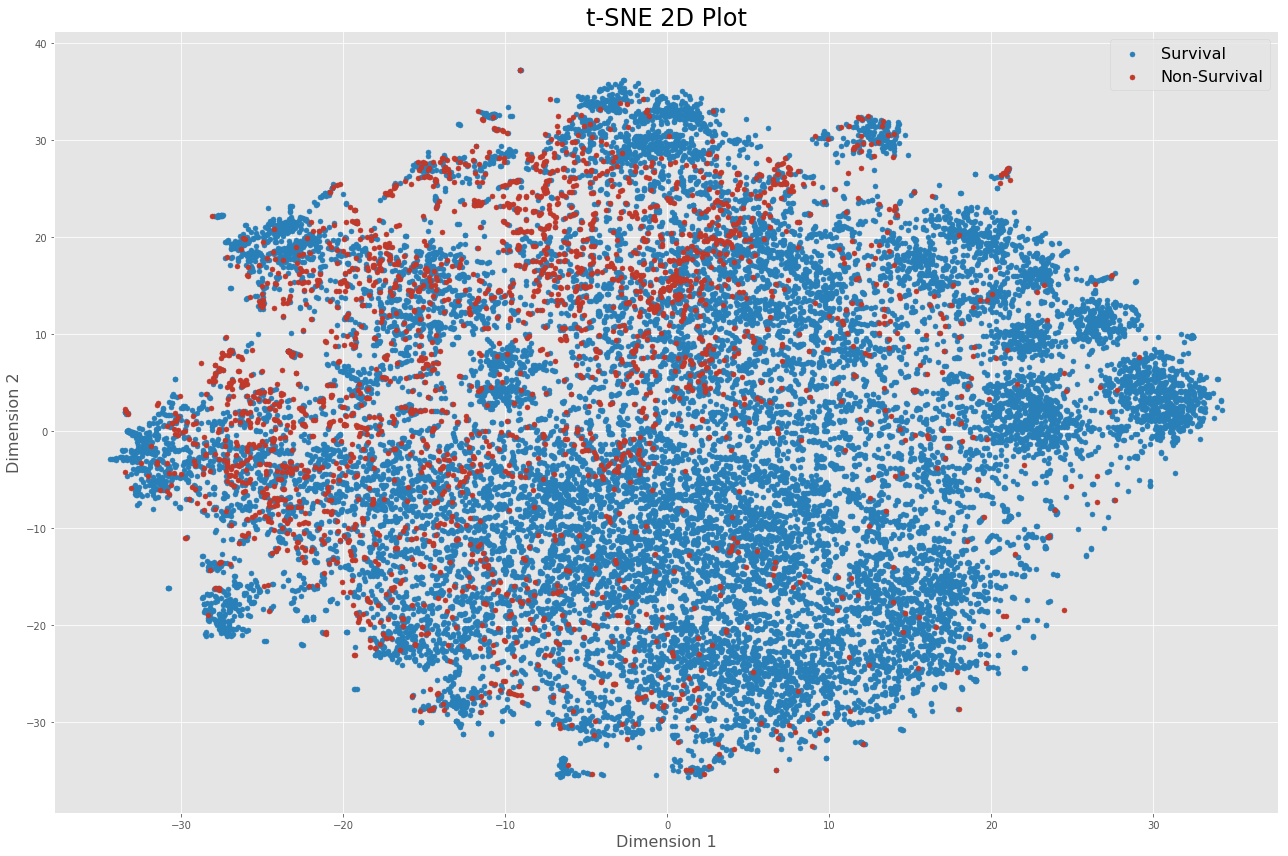

In [12]:
fig, plot = plt.subplots(figsize=(18, 12))
#fig.set_size_inches(25, 25)
plt.prism()

# X_transformed = preprocessor.apply_to_feature_matrix(X_train).T # this crashes when ran twice
colors = [
    ('#2980b9', 'o'), # blue
    ('#c0392b', 'o'), # red

]

labels = np.unique(y_train.get_labels())

for num in range(len(labels)):
    plt.scatter([embedded_data_tsne.T[:,0][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]],
    [embedded_data_tsne.T[:,1][i] for i in range(y_train.get_num_labels()) if y_train.get_value(i) == labels[num]], 25,
    label=['Survival', 'Non-Survival'][num], color = colors[num][0], marker=colors[num][1])#, edgecolors='black')
    
plt.legend(scatterpoints=1, fontsize=16)
plt.title("t-SNE 2D Plot", fontsize=24)
#plot.set_xticks(())
#plot.set_yticks(())
plt.xlabel('Dimension 1', fontsize=16)
plt.ylabel('Dimension 2', fontsize=16)
plt.tight_layout()

## Feature Selection

In [83]:
ffs = RealFeatureSelection()

#bfs = RealFeatureSelection(BACKWARD_ELIMINATION)

TypeError: Cannot create new instances of type 'modshogun.RealFeatureSelection'